In [2]:
import os
import warnings  # 解除警告

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sympy import python
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

warnings.filterwarnings('ignore')

# 数据

In [27]:
data_dir = r'C:\Users\16654\Desktop\train\dataset2'
classes = os.listdir(data_dir)
classes

['切菜板405',
 '剩菜剩饭1165',
 '包4568',
 '厨余五捧花875',
 '厨具一锅1393',
 '厨具三铲勺187',
 '塑料瓶313',
 '塑料瓶一矿泉水食用油754',
 '塑料瓶一立白122',
 '塑料瓶三洗发洗澡1065',
 '塑料瓶二化妆品328',
 '塑料袋947',
 '床褥枕头4146',
 '废弃医疗包装474',
 '废纸一报纸406',
 '废纸三书本3426',
 '废纸三纸巾401',
 '废纸二纸箱709',
 '废纸五卡牌2024',
 '废纸六快递包装572',
 '排插390',
 '易拉罐663',
 '果蔬1069',
 '灯泡459',
 '烟头442',
 '牙签214',
 '玩具1006',
 '玻璃杯瓶1557',
 '电子产品一充电宝442',
 '电子产品三11',
 '电子产品九电脑488',
 '电子产品二充电器438',
 '电子产品五电热水壶1343',
 '电子产品八空调风扇400',
 '电子产品六电池750',
 '电子产品十一U盘628',
 '电子产品十三电子手环1213',
 '电子产品十二电饭煲1142',
 '电子产品十四鼠标1567',
 '电子产品十头戴耳机1302',
 '电子产品四电线插头642',
 '盆376',
 '笔438',
 '筷子455',
 '纸盒一饮料111',
 '纸盒二药品376',
 '罐头414',
 '蛋317',
 '衣服2637',
 '衣架442',
 '陶瓷碗473',
 '鞋子493']

In [28]:
# 划分数据集：训练 测试


In [5]:
data_dir = r'C:\Users\16654\Desktop\train\dataset2'
data_dir_train = r'C:\Users\16654\Desktop\train\dataset2_split\train'
data_dir_test = r'C:\Users\16654\Desktop\train\dataset2_split\test'
batch_size = 32  # 指定了批量处理数据时每个批次的样本数量为32  超参数

# 设置训练集的数据变换，进行数据增强
trainform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(30),  # 随机旋转 -30度到30度之间
    transforms.RandomResizedCrop((224, 224)),  # 随机比例裁剪并进行resize
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomVerticalFlip(p=0.5),  # 随机垂直翻转
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# 设置测试集的数据变换，不进行数据增强，仅使用resize和归一化
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),  # resize
    transforms.ToTensor(),  # 将数据转换为张量
    # 对三通道数据进行归一化(均值，标准差)，数值是从ImageNet数据集上的百万张图片中随机抽样计算得到
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 训练：加载数据、数据加载器
dataset_train = ImageFolder(data_dir_train, transform=trainform_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# 测试：加载数据、数据加载器
dataset_test = ImageFolder(data_dir_test, transform=transform_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size * 2, num_workers=4, pin_memory=True)

In [30]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        break  # 仅显示一个批次的图像

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


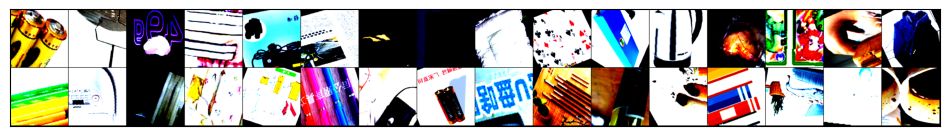

In [31]:
show_batch(dataloader_train)

# 模型

In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# 定义神经网络基类 用于图像分类任务  nn.Module
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):  # 接收一个批次的数据作为输入 进行训练步骤
        images, labels = batch
        out = self(images)  # 生成预测
        loss = F.cross_entropy(out, labels)  # 计算损失  交叉熵损失函数
        return loss

    def validation_step(self, batch):  # 接收一个批次的数据作为输入 进行验证步骤
        images, labels = batch
        out = self(images)  # 生成预测
        loss = F.cross_entropy(out, labels)  # 计算损失  交叉熵损失函数
        acc = accuracy(out, labels)  # 计算准确率
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):  # 每轮训练结束 输出当前轮次的信息
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))


class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset_train.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

# 设备

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            try:
                yield to_device(b, self.device)
            except OSError:
                continue

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# 训练

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# 评估

In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

# 实例化

Epoch 1: train_loss: 3.3033, val_loss: 3.1177, val_acc: 0.7784
Epoch 2: train_loss: 3.1595, val_loss: 3.0877, val_acc: 0.8083
Epoch 3: train_loss: 3.1299, val_loss: 3.0768, val_acc: 0.8281
Epoch 4: train_loss: 3.1167, val_loss: 3.0627, val_acc: 0.8330
Epoch 5: train_loss: 3.1023, val_loss: 3.0628, val_acc: 0.8370
Epoch 6: train_loss: 3.0964, val_loss: 3.0592, val_acc: 0.8440
Epoch 7: train_loss: 3.0921, val_loss: 3.0554, val_acc: 0.8506
Epoch 8: train_loss: 3.0877, val_loss: 3.0481, val_acc: 0.8595
Epoch 9: train_loss: 3.0812, val_loss: 3.0449, val_acc: 0.8731
Epoch 10: train_loss: 3.0809, val_loss: 3.0496, val_acc: 0.8626
Epoch 11: train_loss: 3.0770, val_loss: 3.0464, val_acc: 0.8650
Epoch 12: train_loss: 3.0759, val_loss: 3.0430, val_acc: 0.8732
Epoch 13: train_loss: 3.0719, val_loss: 3.0428, val_acc: 0.8748
Epoch 14: train_loss: 3.0694, val_loss: 3.0428, val_acc: 0.8759
Epoch 15: train_loss: 3.0704, val_loss: 3.0403, val_acc: 0.8776
Epoch 16: train_loss: 3.0663, val_loss: 3.0427, v

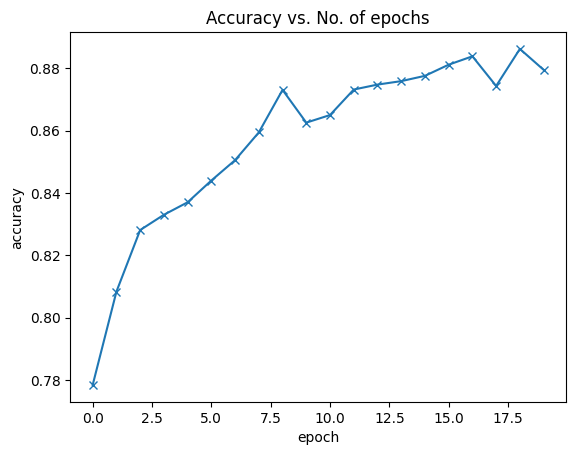

In [36]:
# 实例化模型
model = ResNet()
# 实例化设别驱动
device = get_default_device()
# 数据加载器
dataloader_train = DeviceDataLoader(dataloader_train, device)
dataloader_test = DeviceDataLoader(dataloader_test, device)

# to_device(model, device)
model = to_device(ResNet(), device)

num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

# 训练和评估 保存模型参数
evaluate(model, dataloader_test)
history = fit(num_epochs, lr, model, dataloader_train, dataloader_test, opt_func)
plot_accuracies(history)
torch.save(model.state_dict(), './model7.3.pth')

# 测试

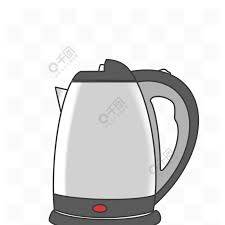

In [6]:
# 加载模型
model = ResNet()
model.load_state_dict(torch.load('model7.3.pth'))
strict = False
model.eval()

# 图像变换
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

img = Image.open(r'C:\Users\16654\Desktop\data_img\a13.jpg')
img

In [7]:
img = transformations(img)
# 预测
with torch.no_grad():
    preds = model(img.unsqueeze(0)).argmax(dim=1)
print(dataset_test.classes[preds.item()])  # 输出预测结果

电子产品二充电器438
